<a href="https://colab.research.google.com/github/KeenanMcConkey/flower-classifier/blob/main/Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 17 Category Flower Dataset

## Strategy: Transfer Learning with PyTorch
Use transfer learning, freeze convolutional layers of imported CNN but train new classification layers to work with flower images.

### Imports

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive

import torch
import torchvision

from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from collections import OrderedDict

### Configuring for Google Colab

In [ ]:
drive.mount('/content/drive')
basedir = '/content/drive/My Drive/Colab Notebooks/Xplor/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load images
**NB** I restructed nature of the jpg directory that was downloaded from http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html to make it easier to use Torch's ImageLoader class

In [ ]:
# Mean/std deviaton expected
resnet_mean = np.array([0.485, 0.456, 0.406])
resnet_std = np.array([0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=resnet_mean, std=resnet_std),
])

In [ ]:
 # Collect all images using ImageFolder
fullset = ImageFolder(basedir + 'jpg', transform=preprocess)

# Split into test/train dataset
train_size = int(0.8 * len(fullset))
test_size = len(fullset) - train_size
train_dataset, test_dataset = random_split(fullset, [train_size, test_size])

# Dataloaders from the datasets
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_dataloader  = DataLoader(test_dataset,  batch_size=8, shuffle=True, num_workers=2)

print('Train dataset: {} images / {} batches'.format(len(train_dataset), len(train_dataloader)))
print('Test dataset:  {} images / {} batches'.format(len(test_dataset),  len(test_dataloader)))

Train dataset: 1088 images / 136 batches
Test dataset:  272 images / 34 batches


In [ ]:
# List of names
class_names = fullset.classes
class_names

['bluebell',
 'buttercup',
 'coltsfoot',
 'cowslip',
 'crocus',
 'daffodil',
 'daisy',
 'dandelion',
 'fritillary',
 'iris',
 'lilyvalley',
 'pansy',
 'snowdrop',
 'sunflower',
 'tigerlily',
 'tulip',
 'windflower']

### View some images
**See PyTorch tutorial**  https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

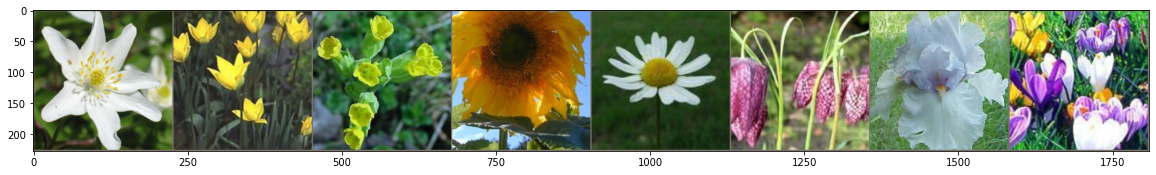

     windflower           tulip         cowslip       sunflower           daisy      fritillary            iris          crocus


In [ ]:
''' Display a normalized tensor as an image '''
def imshow(img):
    # Un-normalize
    for i in range(img.shape[0]):
        img[i] = img[i] * resnet_std[i] + resnet_mean[i]
    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# Show image grid
fig = plt.figure(figsize=(20, 160))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%16s' % class_names[labels[j]] for j in range(8)))

### Configure transfer learning CNN
Using becase its pretty light and easy to use with transfer learning

In [ ]:
# Download VGG19
model = models.vgg19(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
#  Match the FC input layer (25088) to the output number of classes (17) with one hidden layer of 4096
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 17)),
                          ('output', nn.LogSoftmax(dim=1))
]))

In [ ]:
# Freeze the pretrained weights
for parameter in model.parameters():
    parameter.requires_grad = False

In [ ]:
# Replace the classifier portion of VGG19
model.classifier = classifier

In [ ]:
# Send model to CUDA
model.to(torch.device('cuda'))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Train the model

In [ ]:
# HYPERPARAMETERS

# Negative log likelihood loss - good with softmax output
criterion = nn.NLLLoss()

# Adam optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [ ]:
''' TRAIN FUNCTION '''
def train_model(model, criterion, optimizer, num_epochs=5, device='cuda'):
    print(25 * '-')

    # Set to evaluate
    model.train()    # Set model to train

    # Iterare over epochs
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch+1, num_epochs))
        print(25*'-')
        
        running_loss = 0.0 
        running_correct = 0 

        print('Training {} batches'.format(len(train_dataloader)))

        # Iterate through train dataloader
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Set parameter gradients to zero
            optimizer.zero_grad()

            # Forward propagatation
            with torch.enable_grad():
                batch_outputs = model(inputs)
                _, batch_preds = torch.max(batch_outputs, 1)
                batch_loss = criterion(batch_outputs, labels)

                # Backward propagation
                batch_loss.backward()
                optimizer.step()

            # Compute statistics
            running_loss += batch_loss.item() * inputs.size(0)
            running_correct += torch.sum(batch_preds == labels.data)
            #print('Running Loss: {:.4f}, Running Correct: {}'.format(running_loss, running_correct))

        epoch_size = len(train_dataset)
        epoch_loss = running_loss / epoch_size
        epoch_acc = running_correct.double() / epoch_size

        print('Epoch Loss: {:.4f}, Epoch Accuracy: {:.4f}'.format(epoch_loss, epoch_acc))
        print(25 * '-')     

In [ ]:
train_model(model, criterion, optimizer)

-------------------------
Epoch 1 / 5
-------------------------
Training 136 batches


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch Loss: 0.8153, Epoch Accuracy: 0.7528
-------------------------
Epoch 2 / 5
-------------------------
Training 136 batches
Epoch Loss: 0.0248, Epoch Accuracy: 0.9945
-------------------------
Epoch 3 / 5
-------------------------
Training 136 batches
Epoch Loss: 0.0026, Epoch Accuracy: 1.0000
-------------------------
Epoch 4 / 5
-------------------------
Training 136 batches
Epoch Loss: 0.0014, Epoch Accuracy: 1.0000
-------------------------
Epoch 5 / 5
-------------------------
Training 136 batches
Epoch Loss: 0.0010, Epoch Accuracy: 1.0000
-------------------------


### Test the model

In [ ]:
''' TEST FUNCTION '''
def test_model(model, device='cuda'):
    # Evaluation mode
    model.eval()
    print('Testing {} batches'.format(len(test_dataloader)))
    running_loss = 0.0 
    running_correct = 0 


    # Iterate through test dataloader
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Compute outputs
        with torch.no_grad():
            batch_outputs = model(inputs)
            _, batch_preds = torch.max(batch_outputs, 1)
            batch_loss = criterion(batch_outputs, labels)


        # Compute statistics
        running_loss += batch_loss.item() * inputs.size(0)
        running_correct += torch.sum(batch_preds == labels.data)
        #print('Running Loss: {:.4f}, Running Correct: {}'.format(running_loss, running_correct))

    test_size = len(test_dataset)
    test_loss = running_loss / test_size
    test_acc  = running_correct.double() / test_size

    print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss, test_acc))

In [ ]:
test_model(model)

Testing 34 batches
Test Loss: 0.2828, Test Accuracy: 0.9191


### Do some class predictions

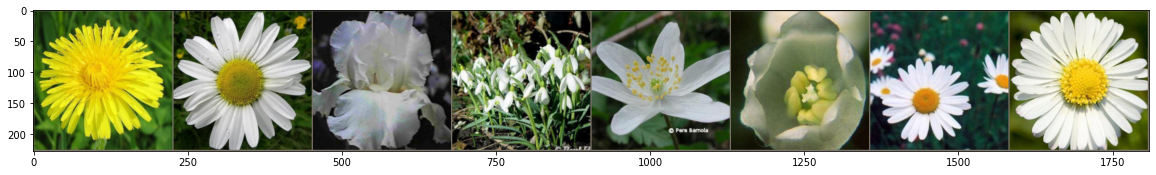

Actl:       dandelion           daisy            iris        snowdrop      windflower      lilyvalley           daisy           daisy
Pred:       dandelion           daisy            iris        snowdrop      windflower      lilyvalley           daisy           daisy


In [ ]:
# Get some random testing images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

# Show image grid
fig = plt.figure(figsize=(20, 160))
imshow(torchvision.utils.make_grid(images))

# Predict classes with model
inputs = images.to(torch.device('cuda'))
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Show actual/predicted classes
print('Actl: ' + ' '.join('%15s' % class_names[labels[j]] for j in range(8)))
print('Pred: ' + ' '.join('%15s' % class_names[preds[j]] for j in range(8)))

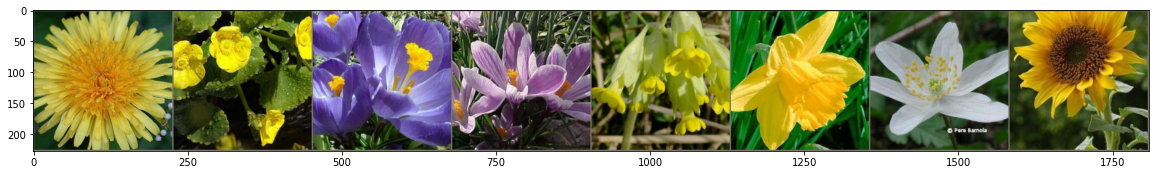

Actl:       dandelion       buttercup          crocus          crocus         cowslip        daffodil      windflower       sunflower
Pred:       dandelion       buttercup          crocus          crocus        daffodil        daffodil      windflower       sunflower


In [ ]:
# Get some random testing images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

# Show image grid
fig = plt.figure(figsize=(20, 160))
imshow(torchvision.utils.make_grid(images))

# Predict classes with model
inputs = images.to(torch.device('cuda'))
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Show actual/predicted classes
print('Actl: ' + ' '.join('%15s' % class_names[labels[j]] for j in range(8)))
print('Pred: ' + ' '.join('%15s' % class_names[preds[j]] for j in range(8)))

### Results
92% Testing accuracy with VGG19 transfer learning.
Could probably optimize further but this is definitely a working classifier